## Image Classification for Poverty Estimation
## Code Appendix
## April 29th, 2019

---

### Content
- Download and merge data
- Data reprocessing and EDA 
- Solution 1: CNN 
- Solution 2: CNN with transfer learning
- Solution 3: Logistic with nightlights 
- Solution 4: Muti-step transfer learning
- Evaluation

---

## Download and merge data

In [53]:
# link to drive folder to access and download data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# set directory
import os
os.chdir("/content/drive/My Drive/image_classification/poverty_estimation/data/")

### Extract nightlights data for Rwanda based on coordinates


In [0]:
import time
import os
import os.path

import gdal
gdal.UseExceptions()
import imageio
import io

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')

import urllib
import pandas as pd
import numpy as np

In [0]:
def read_raster(raster_file):
    """
    Input: 
      path to a raster file (string)
      
    Output:
      x_size : float
          Pixel size
      top_left_x_coords : numpy.ndarray  shape: (number of columns,)
          Longitude of the top-left point in each pixel
      top_left_y_coords : numpy.ndarray  shape: (number of rows,)
          Latitude of the top-left point in each pixel
      centroid_x_coords : numpy.ndarray  shape: (number of columns,)
          Longitude of the centroid in each pixel
      centroid_y_coords : numpy.ndarray  shape: (number of rows,)
          Latitude of the centroid in each pixel
      bands_data : numpy.ndarray  shape: (number of rows, number of columns, 1)
          Pixel value
    """
    
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    # get project coordination
    proj = raster_dataset.GetProjectionRef()
    bands_data = []
    # Loop through all raster bands
    for b in range(1, raster_dataset.RasterCount + 1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())
        no_data_value = band.GetNoDataValue()
    bands_data = np.dstack(bands_data)
    rows, cols, n_bands = bands_data.shape

    # Get the metadata of the raster
    geo_transform = raster_dataset.GetGeoTransform()
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = geo_transform
    
    # Get location of each pixel
    x_size = 1.0 / int(round(1 / float(x_size)))
    y_size = - x_size
    y_index = np.arange(bands_data.shape[0])
    x_index = np.arange(bands_data.shape[1])
    top_left_x_coords = upper_left_x + x_index * x_size
    top_left_y_coords = upper_left_y + y_index * y_size
    # Add half of the cell size to get the centroid of the cell
    centroid_x_coords = top_left_x_coords + (x_size / 2)
    centroid_y_coords = top_left_y_coords + (y_size / 2)

    return (x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data)


In [0]:
def get_cluster_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    """
    Input:
      A point location: (longitude, latitude)
      pixel locations of the raster file: (top_left_x_coords, top_left_y_coords)
    Output: 
      lon_idx : int
          Column index
      lat_idx : int
          Row index
    """
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

In [0]:
raster_file = 'nightlights/F182010.v4d_web.stable_lights.avg_vis.tif'
x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data = read_raster(raster_file)

# save the result in compressed format
np.savez('nightlights/nightlight.npz', top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords, bands_data=bands_data)

### Download daytime satellite images from Google Maps Statics API

In [0]:
from retrying import retry

#@retry(wait_exponential_multiplier=1000, wait_exponential_max=36000)
def save_img(url, file_path, file_name):
    """
    Input:
      url: string
        request url 
      file_path: string
        where to save the image 
      file_name: string
        file name of the image
    Output:
      None
    """
    a = urllib.request.urlopen(url).read()
    b = io.BytesIO(a)
    image = imageio.imread(b, pilmode='RGB')
    # drop images if large area of the image has the same color 
    # (Google API does not have satellite image in that area)
    if np.array_equal(image[:,:10,:],image[:,10:20,:]):
        pass
    else:
        imageio.imsave(file_path + file_name, image[50:450, :, :])

In [0]:
#extract the edges of the country
x_min_shp, x_max_shp, y_min_shp, y_max_shp = (28.903892, 30.850353,-2.800865, -1.099347) # extent obtained from opening the shapefiles in QGIS

left_idx, top_idx = get_cluster_idx(x_min_shp, y_max_shp, top_left_x_coords, top_left_y_coords)
right_idx, bottom_idx = get_cluster_idx(x_max_shp, y_min_shp, top_left_x_coords, top_left_y_coords)

In [0]:
key = 'MY_KEY'
m = 1
for i in range(top_idx, right_idx + 1):
    for j in range(top_idx, bottom_idx + 1):
        lon = centroid_x_coords[i]
        lat = centroid_y_coords[j]
        url = 'https://maps.googleapis.com/maps/api/staticmap?center=' + str(lat) + ',' + \
               str(lon) + '&zoom=16&size=400x500&maptype=satellite&key=' + key
        lightness = bands_data[j, i, 0]
        file_path = 'day' + str(lightness) + '/'
        if not os.path.isdir(file_path):
            os.makedirs(file_path)
        file_name = str(i) + '_' + str(j) +'.jpg'
        save_img(url, file_path, file_name)
        if m % 100 == 0:
            print(m)
        m += 1

## Data preprocessing and EDA

In [0]:
# import basic packages
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt 
plt.style.use('seaborn')
import seaborn as sns

# import keras packages
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import to_categorical

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

# import sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

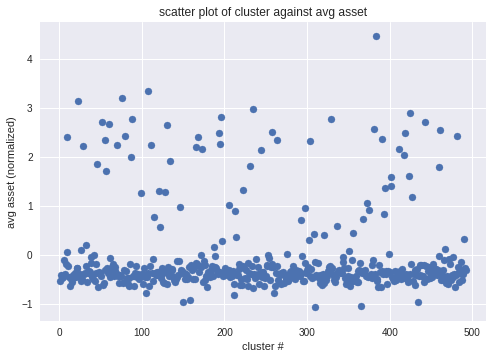

In [0]:
# match images with cluster, wealth (cluster level) and nightlights

clusters = pd.read_csv('rwanda_cluster_avg_asset_2010.csv') 

plt.title('scatter plot of cluster against avg asset')
plt.scatter(clusters.loc[:, 'cluster'], clusters.loc[:,'wlthindf'])
plt.xlabel('cluster #')
plt.ylabel('avg asset (normalized)')
plt.show()

In [0]:
# split wealth into 2 classes (split by median): 1: rich, 0: poor
scores =  clusters.loc[:,'wlthindf']
clusters['wlclass'] = [1.0 if score > np.median(scores) else 0.0 for score in scores]
clusters.groupby(['wlclass'])['cluster'].count()

wlclass
0.0    246
1.0    246
Name: cluster, dtype: int64

In [0]:
# save image file names as keys and corresponding huminosity as values
images = {}
for i in range(64):
    try: 
        dir_ = 'day' + str(i) + '/'
        image_list = os.listdir(dir_)
        images[i] = image_list
    except: 
        pass
# remove .DS_Store
images[0].pop([i for i, image in enumerate(images[0]) if 'DS_Store' in image][0])

# convert to image: luminosity
images = {image: i for i, image_list in images.items() for image in image_list}
len(images)

48175

> 48175 images are downloaded from the Google Maps Static API. This is because the coordinates we included form a rectangle that contain Rwanda and other neighboring areas. 

In [0]:
# get coordinate info to match images with wealth class (at the cluster level)
npzfile = np.load('nightlights/nightlight.npz')
top_left_x_coords = npzfile['top_left_x_coords']
top_left_y_coords = npzfile['top_left_y_coords']
bands_data = npzfile['bands_data']

def get_cluster_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

In [0]:
# convert to image: [luminosity, wealth class]

images_dict = {}

for i, row in clusters.iterrows():
    lon, lat, wlclass = [row['longitude'], row['latitude'], row['wlclass']]
    lon_idx, lat_idx = get_cluster_idx(lon, lat, top_left_x_coords, top_left_y_coords)
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    
    for x in range(left_idx, right_idx + 1):
        for y in range(up_idx, low_idx + 1):
            file_name = str(x) + '_' + str(y) + '.jpg'
            if file_name in images:
                lum = images[file_name]
                images_dict[file_name] = [lum, wlclass]
#             else:
#                 os.remove('day'+str(lum)+'/'+file_name)

In [0]:
images_df = pd.DataFrame.from_dict(images_dict, orient='index')
images_df.reset_index(level=0, inplace=True)
images_df.columns = ['file','luminosity','wlclass']
images_df.head()

,file,luminosity,wlclass
0,25157_9299.jpg,0,0.0
1,25157_9300.jpg,0,0.0
2,25157_9301.jpg,0,0.0
3,25157_9302.jpg,0,0.0
4,25157_9303.jpg,0,0.0


In [0]:
len(images_df)

22204

> 22204 downloaded daytime satellite images have matching wealth class information. We will only consider these images with wealth labels.

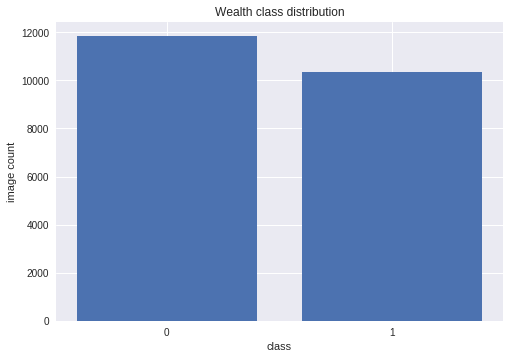

In [0]:
# check class distribution of remaining images

plt.title('Wealth class distribution')
plt.bar(['0','1'],images_df.groupby(['wlclass'])['file'].count())
plt.xlabel('class')
plt.ylabel('image count')
plt.show()

>  We have more images for the poor class than the rich class. We will randomly select the same number of images from each class for further analysis. Due to the limitation of my Google drive storage space and computational power, I randomly sample 2,000 images from each class, resulting in 4,000 images in total. 

> Note that Xie et al (2016) uses 158,000 images for Uganda in total. This is a significant reduction of image size. However, Uganda's area is 241,037 km², while Rwanda is a much smaller country with an area of 26,338 km², almost 10 times smaller than Uganda. And later results show that the relative performance of different solutions still holds with a smaller dataset. Since the goal of this report is to compare the different solutions proposed by Xie et al (2016), rather than outperforming their results,  our dataset is sufficiently large. 

> To compensate the sample loss, we wil also augment our data to generate more training images. 

In [0]:
# randomly sample 2000 images from each class
np.random.seed(3)
images_df = pd.concat([images_df.loc[images_df['wlclass'] == 0].sample(2000), images_df.loc[images_df['wlclass'] == 1].sample(2000)], ignore_index = True)

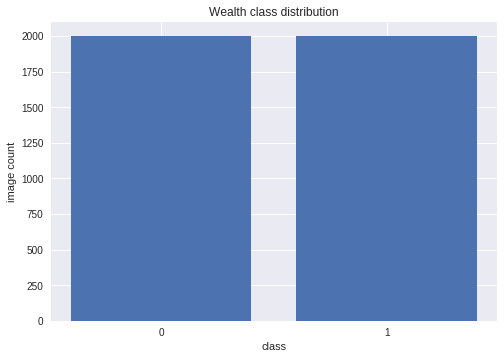

In [0]:
plt.title('Wealth class distribution')
plt.bar(['0','1'],images_df.groupby(['wlclass'])['file'].count())
plt.xlabel('class')
plt.ylabel('image count')
plt.show()

In [0]:
# only save selected samples 

d = images_dict.copy()
for file in d.keys():
    if file not in list(images_df['file']):
        del(images_dict[file])
len(images_dict)

4000

In [0]:
# same dictionary for loading data 

pkl.dump(images_dict, open( "images_dict.pkl", "wb" ) )

In [0]:
# load 4000 satellite images, match them with wealth class and save as compressed file for future use

images_dict = pkl.load(open("images_dict.pkl", "rb" ) )

data = []
labels = []
n_images = len(images_dict)

i = 1
for file, values in images_dict.items():
    i+=1
    if i%100 == 0 or i%n_images == 0:
        print('\rprogress {}/{}'.format(i, n_images), end='')
    lum, wlclass = values
    path = 'day'+str(lum)+'/'+file
    img = image.load_img(path, target_size = (224,224))
    data.append(image.img_to_array(img))
    labels.append(wlclass)
    
np.savez('data_labels.npz', data = data, labels = labels)

progress 4000/4000

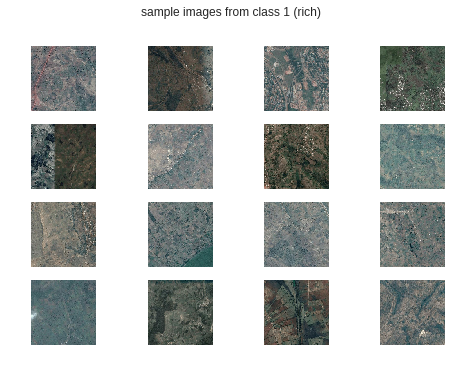

In [52]:
# visualize daytime satellite images
rich = data[np.random.choice(np.where(labels == 1)[0], 16, replace=False)]

plt.suptitle('sample images from class 1 (rich)')
for i in range(len(rich)):
    plt.subplot(4,4,i+1)
    plt.imshow(np.array(rich[i], np.int32))
    plt.axis('off')

plt.show()

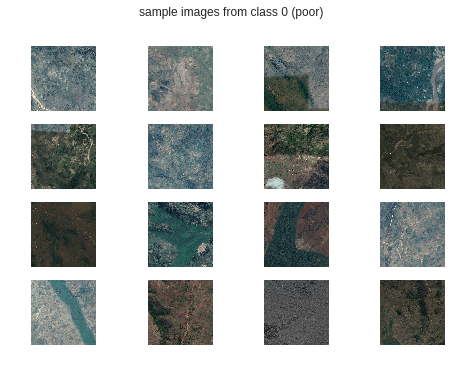

In [49]:
poor = data[np.random.choice(np.where(labels == 0)[0], 16, replace=False)]

plt.suptitle('sample images from class 0 (poor)')
for i in range(len(poor)):
    plt.subplot(4,4,i+1)
    plt.imshow(np.array(poor[i], np.int32))
    plt.axis('off')

plt.show()

---


## Solution 1: CNN with daytime images

In [56]:
# load data and labels
file = np.load('data_labels.npz')
data = file['data']
labels = file['labels']
del(file) # remove variable to free up RAM and GPU space

# split into training and test sets (ratio: 7:3)
data_train, data_test, label_train, label_test = train_test_split(data, 
                                                                  labels, 
                                                                  test_size=0.3, random_state=3)
del([data,labels])

# one-hot
num_classes = 2
label_train = to_categorical(label_train, num_classes)
label_test = to_categorical(label_test, num_classes)

# normalize data
data_train = np.array(data_train).astype('float32')
data_test = np.array(data_test).astype('float32')

# (x-mean)/std
mean = np.mean(data_train,axis=(0,1,2,3))
std = np.std(data_train,axis=(0,1,2,3))
data_train = (data_train-mean)/(std+1e-7)
data_test = (data_test-mean)/(std+1e-7)
del([mean, std])

print("Training set images shape: {}".format(data_train.shape))
print("Training set labels shape: {}".format(label_train.shape))

print("Test set images shape: {}".format(data_test.shape))
print("Test set labels shape: {}".format(label_test.shape))

Training set images shape: (2800, 224, 224, 3)
Training set labels shape: (2800, 2)
Test set images shape: (1200, 224, 224, 3)
Test set labels shape: (1200, 2)


In [0]:
# augment data every batch
def augment_data(generator, X, Y, batch_size = 32 ):
    generator_seed = np.random.randint(1)
    gen_X = generator.flow(X, Y, batch_size = batch_size, seed = generator_seed )

    while True:
        Xi = gen_X.next()
        
        yield Xi[0], Xi[1]

In [0]:
# compile model
model = Sequential()
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (224,224,3), name = 'input'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3,3), activation = 'relu', name = 'conv2'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3,3), activation = 'relu', name = 'conv3'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

opt = SGD(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
# augment training images to compensate sample loss
image_augmentation = ImageDataGenerator( rotation_range = 20,
                                         horizontal_flip = True,
                                         vertical_flip = True,
                                         width_shift_range = .3,
                                         height_shift_range =.3,
                                         zoom_range = .1 )
train_generator = augment_data(image_augmentation, data_train, label_train, batch_size = 32)

# add early stopping: stop training if val_loss hasn't decreased for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10) 

# run model and save history 
history = model.fit_generator(train_generator, 
                              steps_per_epoch = len(data_train)//32, 
                              validation_data=(data_test,label_test),
                              callbacks = [early_stopping],
                              epochs=100, verbose = 1)

In [0]:
def plot_loss_acc(history):
    '''
    input: 
      training history from fitting a CNN model
      history is a nested list with [training_loss, training_accuracy, validation_loss, validation_accuracy]
    output:
      side-by-side plots of accuracy and loss
    '''
    plt.figure(figsize = (15,6))
    
    plt.subplot(1,2,1)
    plt.title('Accuracy')
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['train accuracy','test accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy rate (%)')
    
    plt.subplot(1,2,2)
    plt.title('Categorical Cross-Entropy Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train loss','test loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.show()

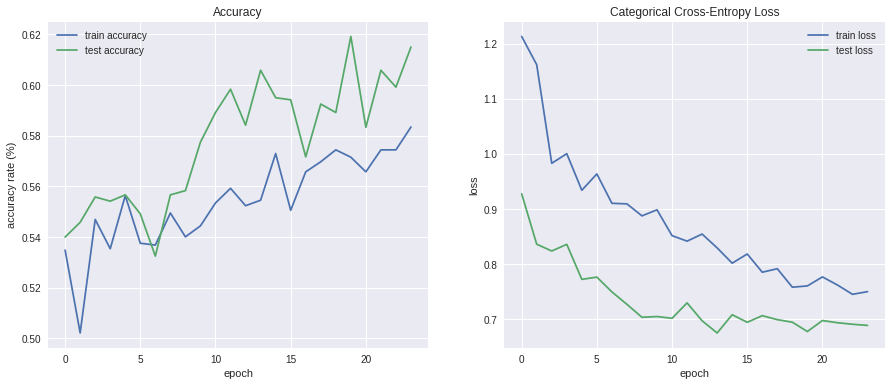

In [0]:
# Elosses and accuracies
plot_loss_acc(history)

In [0]:
# predict and reduce to 1d array
probs = model.predict(data_test, verbose=0)
classes = model.predict_classes(data_test, verbose=0)

# accuracy
day_acc = model.evaluate(data_test, label_test, batch_size = 32, verbose = 0)[1]
# precision tp / (tp + fp)
day_pre = precision_score(label_test[:,1], classes)
# recall: tp / (tp + fn)
day_rec = recall_score(label_test[:,1], classes)
# f1: 2 tp / (2 tp + fp + fn)
day_f1 = f1_score(label_test[:,1], classes)
# auc
day_auc = roc_auc_score(label_test[:,1], probs[:,1])

pkl.dump([day_acc, day_pre, day_rec, day_f1, day_auc], open('day_metrics.pkl', 'wb'))

In [0]:
day_metrics = pkl.load(open('day_metrics.pkl', 'rb'))
day_metrics

[0.615, 0.68, 0.4271356783919598, 0.5246913580246914, 0.6584470167309738]

## Solution 2: CNN with transfer learning using daytime images

In [0]:
# download and get summary of convoluational layers from VGG16 net
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
# dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# output tensor of the last VGG layer
x = layer_dict['block5_pool'].output

# stack fully connected layer and prediction layer  
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=x)

# pre-trained bottom layers are not trainable
for layer in model.layers[:-4]:
    layer.trainable = False

# compile it
opt = SGD(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
# augment training images to compensate sample loss
image_augmentation = ImageDataGenerator( rotation_range = 20,
                                         horizontal_flip = True,
                                         vertical_flip = True,
                                         width_shift_range = .3,
                                         height_shift_range =.3,
                                         zoom_range = .1 )
train_generator = augment_data(image_augmentation, data_train, label_train, batch_size = 32)

# add early stopping: stop training if val_loss hasn't decreased for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10) 

# run model and save history 
history = model.fit_generator(train_generator, 
                              steps_per_epoch = len(data_train)//32, 
                              validation_data=(data_test,label_test),
                              callbacks = [early_stopping],
                              epochs=100, verbose = 1)

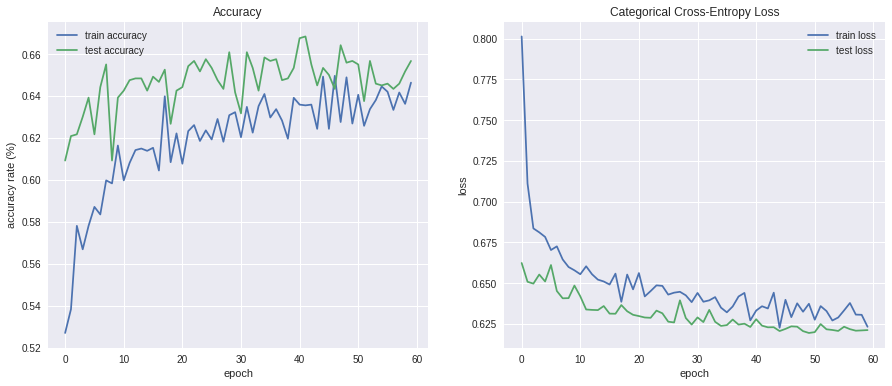

In [0]:
# Evaluate losses and accuracies
plot_loss_acc(history)

In [0]:
# predict and reduce to 1d array
probs = model.predict(data_test, verbose=0)
classes = np.argmax(probs,axis=1)

# accuracy
day_tl_acc = model.evaluate(data_test, label_test, batch_size = 32, verbose = 0)[1]
# precision tp / (tp + fp)
day_tl_pre = precision_score(label_test[:,1], classes)
# recall: tp / (tp + fn)
day_tl_rec = recall_score(label_test[:,1], classes)
# f1: 2 tp / (2 tp + fp + fn)
day_tl_f1 = f1_score(label_test[:,1], classes)
# auc
day_tl_auc = roc_auc_score(label_test[:,1], probs[:,1])

pkl.dump([day_tl_acc, day_tl_pre, day_tl_rec, day_tl_f1, day_tl_auc], open('day_tl_metrics.pkl', 'wb'))

In [0]:
day_tl_metrics = pkl.load(open('day_tl_metrics.pkl', 'rb'))
day_tl_metrics

[0.6566666666666666,
 0.6931106471816284,
 0.5561139028475712,
 0.6171003717472119,
 0.7024508946056984]

## Solution 3: Ridge logistic with nightlights

In [0]:
# logistic 
images_dict = pkl.load(open("images_dict.pkl", "rb" ))

light = np.array([lum for lum, wlclass in images_dict.values()]).reshape(-1,1)
wealth = np.array([wlclass for lum, wlclass in images_dict.values()])

light_train, light_test, wealth_train, wealth_test = train_test_split(light, wealth, test_size=0.3, random_state=3)


ridge = RidgeClassifierCV(alphas = np.arange(0.1,10,20), normalize = True, cv = 10).fit(X = light_train, y = wealth_train)

In [0]:
classes = ridge.predict(light_test)
confidence = ridge.decision_function(light_test)

# accuracy
light_acc = ridge.score(X = light_test, y = wealth_test)
# precision tp / (tp + fp)
light_pre = precision_score(wealth_test, classes)
# recall: tp / (tp + fn)
light_rec = recall_score(wealth_test, classes)
# f1: 2 tp / (2 tp + fp + fn)
light_f1 = f1_score(wealth_test, classes)
# auc
light_auc = roc_auc_score(wealth_test, confidence)

pkl.dump([light_acc, light_pre, light_rec, light_f1, light_auc], open('light_metrics.pkl', 'wb'))

In [0]:
light_metrics = pkl.load(open('light_metrics.pkl', 'rb'))
light_metrics

[0.545,
 0.9047619047619048,
 0.09547738693467336,
 0.17272727272727273,
 0.5430649655130269]

## Solution 4: Multi-step Transfer Learning

In [0]:
images_dict = pkl.load(open("images_dict.pkl", "rb" ))

wealth = [wlclass for lum, wlclass in images_dict.values()]
light = [lum for lum, wlclass in images_dict.values()]

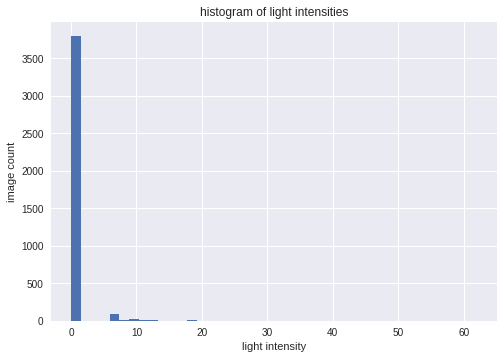

In [0]:
plt.title('histogram of light intensities')
plt.hist(light, bins = len(np.unique(light)))
plt.xlabel('light intensity')
plt.ylabel('image count')
plt.show()

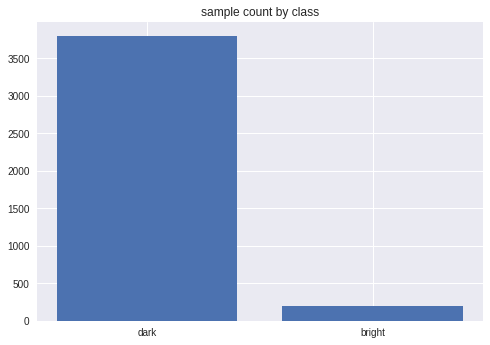

In [0]:
# split nightlight intensity into two classes and visualize class distribution
plt.title('sample count by class')
plt.bar(x=['dark','bright'],\
        height=[sum([1 for l in light if l == 0]),sum([1 for l in light if l != 0])])
plt.show()

In [0]:
vgg_model= VGG16(weights='imagenet', include_top=False)

def get_input_feature(img_path):
    img = image.load_img(img_path, target_size = (400,400,3))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = imagenet_utils.preprocess_input(x)
    features = vgg_model.predict(x)
    return features[0]

In [0]:
labels = [0 if l == 0 else 1 for l in light]

data = []
n_images = len(images_dict)

i = 0
for file, [lum, wlclass] in list(images_dict.items()):
    i+=1
    path = 'day' + str(lum) + '/' + file
    a = get_input_feature(path)
    data.append(a)
    if i % 100 == 0 or i % n_images == 0:
        print('\rprogress {}/{}'.format(i,n_images), end="")

np.savez('light_cnn_data.npz', data = data, labels = labels)

progress 4000/4000

In [0]:
file = np.load('light_cnn_data.npz')
data = file['data']
labels = file['labels']
del(file)

data_train, data_test, label_train, label_test = train_test_split(data, 
                                                                  labels, 
                                                                  test_size=0.3, random_state=3)
del([data,labels])

# one-hot
num_classes = 2
label_train = to_categorical(label_train, num_classes)
label_test = to_categorical(label_test, num_classes)

# normalize data
data_train = np.array(data_train).astype('float32')
data_test = np.array(data_test).astype('float32')

# (x-mean)/std
mean = np.mean(data_train,axis=(0,1,2,3))
std = np.std(data_train,axis=(0,1,2,3))
data_train = (data_train-mean)/(std+1e-7)
data_test = (data_test-mean)/(std+1e-7)
del([mean, std])

print("Training set images shape: {}".format(data_train.shape))
print("Training set labels shape: {}".format(label_train.shape))

print("Test set images shape: {}".format(data_test.shape))
print("Test set labels shape: {}".format(label_test.shape))

Training set images shape: (2800, 12, 12, 512)
Training set labels shape: (2800, 2)
Test set images shape: (1200, 12, 12, 512)
Test set labels shape: (1200, 2)


In [0]:
def augment_data(generator, X, Y, batch_size = 32):
    generator_seed = np.random.randint(1)
    gen_X = generator.flow(X, Y, batch_size = batch_size, seed = generator_seed )

    while True:
        Xi = gen_X.next()
        
        yield Xi[0], Xi[1]

In [0]:
# add convolutional layers to VGGnet
model = Sequential()
model.add(Conv2D(4096, (6, 6), strides = (6,6), activation='relu', input_shape=(12, 12, 512), name='input'))
model.add(Dropout(rate = 0.25))
model.add(Conv2D(4096, (1, 1), strides = (1,1), activation='relu', name='conv_7'))
model.add(Dropout(rate = 0.25))
model.add(Conv2D(4096, (1, 1), strides = (1,1), activation='relu', name='conv_8'))
model.add(AveragePooling2D((2, 2), name='avg_pool'))

# fully convolutional: no full layer
model.add(Flatten(name='flatten'))
model.add(Dense(2, activation = 'softmax'))

# use stochastic gradient descent as optimizer
opt = SGD(lr=1e-2)

# compile model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# augment training images to compensate sample loss
image_augmentation = ImageDataGenerator( rotation_range = 20,
                                         horizontal_flip = True,
                                         vertical_flip = True,
                                         width_shift_range = .3,
                                         height_shift_range =.3,
                                         zoom_range = .1 )
train_generator = augment_data(image_augmentation, data_train, label_train, batch_size = 32)

# add early stopping: stop training if val_loss hasn't decreased for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10) 

# run model and save history 
history = model.fit_generator(train_generator, 
                              steps_per_epoch = len(data_train)//32, 
                              validation_data=(data_test,label_test),
                              class_weight = {0:1, 1:19}, # sum(dark)/ sum(bright) ~= 19
                              callbacks = [early_stopping],
                              epochs=100, verbose = 1)

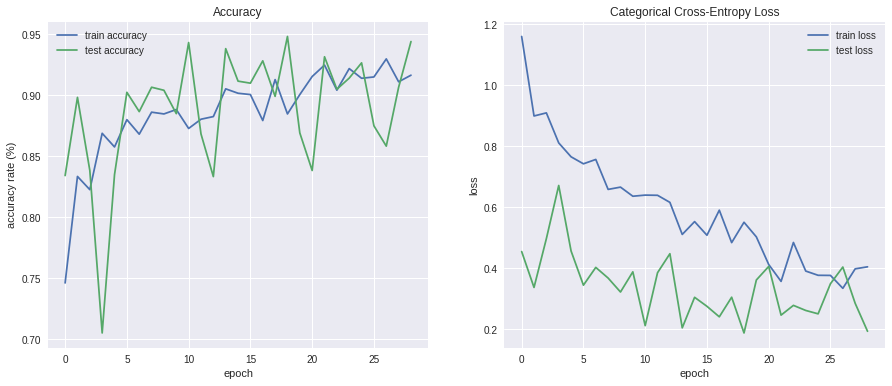

In [0]:
plot_loss_acc(history)

In [0]:
# predict and reduce to 1d array
probs = model.predict(data_test, verbose=0)
classes = np.argmax(probs,axis=1)

# accuracy
light_inter_acc = model.evaluate(data_test, label_test, batch_size = 32, verbose = 0)[1]
# precision tp / (tp + fp)
light_inter_pre = precision_score(label_test[:,1], classes)
# recall: tp / (tp + fn)
light_inter_rec = recall_score(label_test[:,1], classes)
# f1: 2 tp / (2 tp + fp + fn)
light_inter_f1 = f1_score(label_test[:,1], classes)
# auc
light_inter_auc = roc_auc_score(label_test[:,1], probs[:,1])

In [0]:
[light_inter_acc,light_inter_pre,light_inter_rec,light_inter_f1,light_inter_auc]

[0.9441666666666667,
 0.47058823529411764,
 0.5079365079365079,
 0.48854961832061067,
 0.8562912705392915]

> This is just the intermediate step. We don't care too much about the accuarcy. We want features that can serve as a good proxy for wealth.

In [0]:
light_tl_model = Model(inputs=model.input, outputs=model.get_layer('conv_8').output)

In [0]:
data = np.load('light_cnn_data.npz')['data']
features = []

n_images = len(data)

i=0
for tl_output in data:
    i += 1
    if i % 100 == 0 or i % n_images == 0:
        print('\rprogress {}/{}'.format(i,n_images), end="")
        
    features.append(light_tl_model.predict(np.expand_dims(tl_output, axis=0)))

progress 4000/4000

In [0]:
# check output feature size
features[0].shape

(1, 2, 2, 4096)

In [0]:
np.savez('light_tl_features.npz', features = features)

In [0]:
# run ridge logistic to estimate wealth class
features = np.load('light_tl_features.npz')['features']
features = [feature.reshape((1*2*2*4096)) for feature in features]
labels = np.load('data_labels.npz')['labels']

features_train, features_test, label_train, label_test = train_test_split(features, labels, test_size=0.3, random_state=3)
del([features, labels])

# reduce dimensions to avoid overfitting
pca = PCA(n_components=100)
pca.fit(features_train)
features_train = pca.transform(features_train)
features_test = pca.transform(features_test)

ridge = RidgeClassifierCV(alphas = np.arange(0.1,10,20), normalize = True, cv = 10).fit(X = features_train, y = label_train)

In [0]:
classes = ridge.predict(features_test)
confidence = ridge.decision_function(features_test)

# accuracy
light_tl_acc = ridge.score(X = features_test, y = label_test)
# precision tp / (tp + fp)
light_tl_pre = precision_score(label_test, classes)
# recall: tp / (tp + fn)
light_tl_rec = recall_score(label_test, classes)
# f1: 2 tp / (2 tp + fp + fn)
light_tl_f1 = f1_score(label_test, classes)
# auc
light_tl_auc = roc_auc_score(label_test, confidence)

pkl.dump([light_tl_acc, light_tl_pre, light_tl_rec, light_tl_f1, light_tl_auc], open('light_tl_metrics.pkl', 'wb'))

In [0]:
light_tl_metrics = pkl.load(open('light_tl_metrics.pkl', 'rb'))
light_tl_metrics

[0.6733333333333333,
 0.6937618147448015,
 0.6147403685092128,
 0.6518650088809947,
 0.7084482667622247]

## Evaluation

In [0]:
day_metrics = pkl.load(open('day_metrics.pkl', 'rb'))
day_tl_metrics = pkl.load(open('day_tl_metrics.pkl', 'rb'))
light_metrics = pkl.load(open('light_metrics.pkl', 'rb'))
light_tl_metrics = pkl.load(open('light_tl_metrics.pkl', 'rb'))

In [0]:
pd.DataFrame(np.array([day_metrics, day_tl_metrics, light_metrics, light_tl_metrics]),
                          columns = ['accuracy','precision', 'recall', 'F1', 'AUC'],
                          index = ['CNN','direct_transfer', 'nightlight', 'multistep_transfer']).transpose()

,CNN,direct_transfer,nightlight,multistep_transfer
accuracy,0.615000,0.656667,0.545000,0.673333
precision,0.680000,0.693111,0.904762,0.693762
recall,0.427136,0.556114,0.095477,0.614740
F1,0.524691,0.617100,0.172727,0.651865
AUC,0.658447,0.702451,0.543065,0.708448


<insert image here>
  
 We have successfully replicated the results from Xie et al (2016). Multistep transfer learning outperforms all the other approaches in all five evaluation metrics. Note that in the paper, poor is interpreted as the 'positive' class, while here I have done the opposite. This is why our precision and recall scores are flipped.

---
**End of Report**